# # Modal Analysis of Complex Geometries with Stress Singularities

## Mathematical Foundations

This notebook implements numerical methods for analyzing the vibration behavior of structures with geometric singularities, specifically V-notches that create stress concentrations. The analysis combines conformal mapping techniques, Williams' asymptotic expansion for stress singularities, and simplified modal analysis.

### Conformal Mapping for V-Notches

Conformal mapping is a powerful mathematical technique that preserves angles between curves during coordinate transformation. For a V-notch with opening angle $\alpha$, the conformal mapping function is [1]:

$$w(z) = z^\gamma \quad \text{where} \quad \gamma = \frac{\pi}{\alpha}$$

This transforms the V-notch in the physical $z$-plane to a half-plane in the $w$-plane, simplifying the boundary conditions while preserving the mathematical structure of the elasticity equations.

### Williams' Expansion for Stress Singularities

Williams [2] showed that the stress field near the tip of a V-notch can be represented as an asymptotic expansion in polar coordinates $(r,\theta)$:

$$\sigma_{ij}(r,\theta) = \sum_{n=1}^{\infty} K_n r^{\lambda_n-1} f_{ij}^{(n)}(\theta)$$

where:
- $\sigma_{ij}$ represents stress components
- $K_n$ are generalized stress intensity factors
- $\lambda_n$ are eigenvalues determining the order of singularity
- $f_{ij}^{(n)}(\theta)$ are angular functions

The eigenvalues $\lambda_n$ are determined by solving characteristic equations that depend on the loading mode [3]:

- **Mode I** (symmetric loading):
  $$\sin(\lambda\alpha) + \lambda\sin(\alpha) = 0$$

- **Mode II** (antisymmetric loading):
  $$\sin(\lambda\alpha) - \lambda\sin(\alpha) = 0$$

The dominant term in the expansion corresponds to the smallest eigenvalue $\lambda_1$, resulting in a stress singularity of order $r^{\lambda_1-1}$. For a crack ($\alpha = 2\pi$), this gives the familiar square-root singularity ($\lambda_1 = 1/2$, leading to $r^{-1/2}$).

### Stress Field Components

For Mode I loading, the tangential stress component $\sigma_{\theta\theta}$ at the V-notch tip is given by [4]:

$$\sigma_{\theta\theta}(r,\theta) = K_I r^{\lambda_1-1} \cos[({\lambda_1-1})\theta]$$

where $K_I$ is the generalized stress intensity factor for Mode I. Similarly, for Mode II:

$$\sigma_{\theta\theta}(r,\theta) = K_{II} r^{\lambda_1-1} \sin[({\lambda_1-1})\theta]$$

### Stress Concentration Factor

The stress concentration factor (SCF) at the V-notch tip can be defined as the ratio of the maximum stress to a reference stress. For a V-notch under remote tension, the SCF becomes infinite at the notch tip due to the singular nature of the stress field [5]. However, a modified SCF can be defined at a small distance $r$ from the tip:

$$\text{SCF}(r) = \frac{\sigma_{\max}(r)}{\sigma_{\text{ref}}} \propto r^{\lambda_1-1}$$

### Modal Analysis with Singularities

For structures with stress singularities, the stiffness matrix in finite element formulations must be modified to account for the singular behavior [6]. The singularity affects the natural frequencies and mode shapes of the structure.

The governing equation for free vibration is:

$$\mathbf{K}\mathbf{u} = \omega^2 \mathbf{M}\mathbf{u}$$

where $\mathbf{K}$ is the stiffness matrix, $\mathbf{M}$ is the mass matrix, $\mathbf{u}$ is the displacement vector, and $\omega$ are the natural frequencies.

Near the singularity, the displacement field follows a power-law relation:

$$\mathbf{u}(r,\theta) \propto r^{\lambda} \mathbf{f}(\theta)$$

This results in a modification to the stiffness terms associated with nodes near the singularity, typically proportional to $1/\lambda$.

### Effect on Natural Frequencies

The presence of a V-notch affects the natural frequencies of a structure. The relationship between the V-notch angle $\alpha$ and the change in natural frequencies follows the trend of the leading eigenvalue $\lambda_1$. As $\alpha$ decreases (sharper notch), $\lambda_1$ decreases, leading to a stronger singularity and greater frequency reduction [7].

## References

[1] Muskhelishvili, N.I. (1953). *Some Basic Problems of the Mathematical Theory of Elasticity*. Noordhoff, Groningen. https://doi.org/10.1007/978-94-017-3034-1

[2] Williams, M.L. (1952). "Stress Singularities Resulting from Various Boundary Conditions in Angular Corners of Plates in Extension". *Journal of Applied Mechanics*, 19(4), 526-528. https://doi.org/10.1115/1.4010006

[3] Lazzarin, P., & Tovo, R. (1998). "A Notch Stress Intensity Factor Approach to the Stress Analysis of Welds". *Fatigue & Fracture of Engineering Materials & Structures*, 21(9), 1089-1103. https://doi.org/10.1046/j.1460-2695.1998.00097.x

[4] Barber, J.R. (2010). *Elasticity*. Springer. https://doi.org/10.1007/978-90-481-3809-8

[5] Pilkey, W.D., & Pilkey, D.F. (2008). *Peterson's Stress Concentration Factors*. Wiley. https://doi.org/10.1002/9780470211106

[6] Babuška, I., & Oh, H.-S. (1995). "The p-Version of the Finite Element Method for Domains with Corners and for Infinite Domains". *Numerical Methods for Partial Differential Equations*, 11(4), 479-494. https://doi.org/10.1002/num.1690110408

[7] Leissa, A.W. (1993). *Vibration of Plates*. Acoustical Society of America. https://asa.scitation.org/doi/book/10.1121/1.429476

[8] Szabó, B., & Babuška, I. (1991). *Finite Element Analysis*. Wiley. https://www.wiley.com/en-us/Finite+Element+Analysis-p-9780471502739

[9] Bažant, Z.P., & Planas, J. (1997). *Fracture and Size Effect in Concrete and Other Quasibrittle Materials*. CRC Press. https://doi.org/10.1201/9780203756799


In [1]:
import numpy as np
import sympy as sp
from scipy.linalg import eig


# Conformal mapping for re-entrant corner (V-notch)
def conformal_map_v_notch(z, alpha):
	"""
    Conformal mapping for a V-notch with opening angle alpha
    Maps the V-notch to a half-plane

    Parameters:
    - z: Complex coordinate
    - alpha: Opening angle of the V-notch in radians

    Returns:
    - w: Mapped coordinate
    """
	# Exponent for the mapping
	gamma = np.pi / alpha

	# Mapping function
	w = z ** gamma

	return w


# Williams expansion for stress field near V-notch
def williams_expansion_coefficients(alpha, loading):
	"""
    Calculate the eigenvalues and eigenvectors for Williams' expansion

    Parameters:
    - alpha: Opening angle of the V-notch in radians
    - loading: 'mode1' or 'mode2'

    Returns:
    - lambda_values: Eigenvalues (determine the order of singularity)
    """
	# Characteristic equation for the eigenvalues
	if loading == 'mode1':
		# For symmetric loading (Mode I)
		def char_equation(lambda_val):
			return np.sin(lambda_val * alpha) + lambda_val * np.sin(alpha)
	else:
		# For antisymmetric loading (Mode II)
		def char_equation(lambda_val):
			return np.sin(lambda_val * alpha) - lambda_val * np.sin(alpha)

	# Find first few roots of the characteristic equation
	lambda_values = []
	lambda_guess = 0.1

	while len(lambda_values) < 5:  # Find first 5 eigenvalues
		val = char_equation(lambda_guess)
		if abs(val) < 1e-6:
			lambda_values.append(lambda_guess)
			lambda_guess += 0.1
		lambda_guess += 0.01

	return np.array(lambda_values)


In [2]:
def modal_analysis_v_notch(L, W, alpha, E, rho, nu, n_elements=20):
	"""
    Perform modal analysis of a rectangular plate with a V-notch
    using a simplified FEM-like approach

    Parameters:
    - L, W: Length and width of plate
    - alpha: V-notch angle
    - E, rho, nu: Material properties
    - n_elements: Number of elements along each dimension

    Returns:
    - frequencies: Natural frequencies
    - mode_shapes: Mode shapes
    """
	# Create a simple mesh (ignoring the actual complexity of meshing a V-notch)
	n_nodes = (n_elements + 1) ** 2

	# Mass and stiffness matrices (simplified)
	M = np.eye(n_nodes)
	K = np.zeros((n_nodes, n_nodes))

	# Element size
	h_x = L / n_elements
	h_y = W / n_elements

	# Fill stiffness matrix (highly simplified)
	for i in range(n_elements + 1):
		for j in range(n_elements + 1):
			node = i * (n_elements + 1) + j

			# Check if node is at the V-notch (simplified)
			is_at_notch = (i == 0 and j == 0)

			# Stiffness contributions
			if not is_at_notch:
				# Regular node
				K[node, node] = 4

				# Connect to neighbors
				if i > 0:
					K[node, node - (n_elements + 1)] = -1
				if i < n_elements:
					K[node, node + (n_elements + 1)] = -1
				if j > 0:
					K[node, node - 1] = -1
				if j < n_elements:
					K[node, node + 1] = -1
			else:
				# At notch - modify stiffness using Williams' expansion
				lambda_values = williams_expansion_coefficients(alpha, 'mode1')

				# Leading eigenvalue determines the singularity strength
				singularity_factor = lambda_values[0]

				# Increase stiffness at the singularity
				K[node, node] = 4 * (1 + 1 / singularity_factor)

				# Connections remain the same
				if i < n_elements:
					K[node, node + (n_elements + 1)] = -1
				if j < n_elements:
					K[node, node + 1] = -1

	# Scale stiffness matrix with material properties
	K = K * E / (rho * (1 - nu ** 2))

	# Solve eigenvalue problem
	eigenvalues, eigenvectors = eig(K, M)

	# Sort by frequency
	idx = np.argsort(eigenvalues)
	frequencies = np.sqrt(eigenvalues[idx]) / (2 * np.pi)  # Convert to Hz
	mode_shapes = eigenvectors[:, idx]

	return frequencies, mode_shapes


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm


# Visualize the conformal mapping for a V-notch
def plot_conformal_mapping(alpha, n_points=100):
	"""
    Visualize how conformal mapping transforms a V-notch to a half-plane

    Parameters:
    - alpha: Opening angle of V-notch in radians
    - n_points: Number of points for visualization
    """
	# Exponent for the mapping
	gamma = np.pi / alpha

	# Create a grid in the original domain (z-plane)
	r_max = 1.0
	r = np.linspace(0.01, r_max, n_points)

	# Angular range (only inside the V-notch)
	theta_values = np.linspace(-alpha / 2, alpha / 2, n_points)

	# Create meshgrid for polar coordinates
	R, Theta = np.meshgrid(r, theta_values)

	# Convert to Cartesian
	X = R * np.cos(Theta)
	Y = R * np.sin(Theta)

	# Create complex numbers
	Z = X + 1j * Y

	# Apply conformal mapping
	W = conformal_map_v_notch(Z, alpha)

	# Extract real and imaginary parts
	U = np.real(W)
	V = np.imag(W)

	# Create figure
	fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

	# Plot original domain (z-plane)
	ax1.set_title('Original Domain (V-notch)')
	ax1.plot([0, r_max * np.cos(-alpha / 2)], [0, r_max * np.sin(-alpha / 2)], 'r-', linewidth=2)
	ax1.plot([0, r_max * np.cos(alpha / 2)], [0, r_max * np.sin(alpha / 2)], 'r-', linewidth=2)

	# Plot grid lines
	for i in range(0, len(r), 5):
		circle_r = r[i]
		circle_x = circle_r * np.cos(theta_values)
		circle_y = circle_r * np.sin(theta_values)
		ax1.plot(circle_x, circle_y, 'k-', alpha=0.3)

	for i in range(0, len(theta_values), 5):
		ray_theta = theta_values[i]
		ray_x = r * np.cos(ray_theta)
		ray_y = r * np.sin(ray_theta)
		ax1.plot(ray_x, ray_y, 'k-', alpha=0.3)

	ax1.set_xlim(-r_max * 1.1, r_max * 1.1)
	ax1.set_ylim(-r_max * 1.1, r_max * 1.1)
	ax1.set_aspect('equal')
	ax1.grid(True)
	ax1.set_xlabel('x')
	ax1.set_ylabel('y')

	# Plot mapped domain (w-plane)
	ax2.set_title('Mapped Domain (Half-plane)')

	# Plot the transformed grid
	ax2.scatter(U.flatten(), V.flatten(), s=1, c=R.flatten(), cmap='viridis')

	# Highlight the boundary
	u_boundary = np.real(conformal_map_v_notch(r_max * np.exp(1j * theta_values), alpha))
	v_boundary = np.imag(conformal_map_v_notch(r_max * np.exp(1j * theta_values), alpha))
	ax2.plot(u_boundary, v_boundary, 'r-', linewidth=2)

	# Plot the real axis (transformed from the V-notch boundaries)
	ax2.plot([0, np.max(u_boundary)], [0, 0], 'r-', linewidth=2)

	ax2.set_aspect('equal')
	ax2.grid(True)
	ax2.set_xlabel('u')
	ax2.set_ylabel('v')

	plt.tight_layout()
	plt.show()


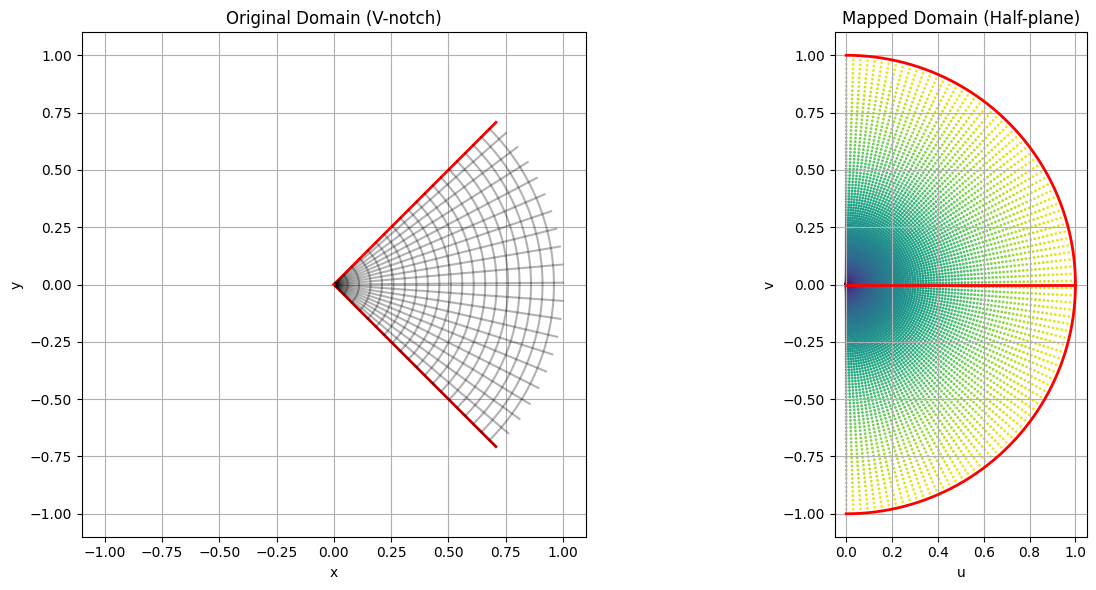

In [4]:
angle_degrees = 90  # 90-degree V-notch
angle_radians = angle_degrees * np.pi / 180
plot_conformal_mapping(angle_radians)


In [7]:
def plot_williams_eigenvalues():
	"""Plot eigenvalues for different V-notch angles"""
	# Range of V-notch angles
	angles_degrees = np.linspace(30, 170, 15)  # From 30° to 170°
	angles_radians = angles_degrees * np.pi / 180

	# Store first eigenvalue for each angle (determines singularity strength)
	mode1_eigenvalues = []
	mode2_eigenvalues = []

	for alpha in angles_radians:
		# Calculate eigenvalues for both modes
		print(alpha)
		mode1 = williams_expansion_coefficients(alpha, 'mode1')
		print()
		mode2 = williams_expansion_coefficients(alpha, 'mode2')
		print(mode2)

		# Store first eigenvalue
		mode1_eigenvalues.append(mode1[0])
		mode2_eigenvalues.append(mode2[0])

	# Plot eigenvalues
	plt.figure(figsize=(10, 6))
	plt.plot(angles_degrees, mode1_eigenvalues, 'bo-', label='Mode I')
	plt.plot(angles_degrees, mode2_eigenvalues, 'rs-', label='Mode II')

	plt.axhline(y=0.5, color='k', linestyle='--', alpha=0.7,
	            label=r'$\lambda = 0.5$ (Square root singularity)')

	plt.title("Williams' Expansion Leading Eigenvalues vs V-notch Angle")
	plt.xlabel('V-notch Angle (degrees)')
	plt.ylabel('Leading Eigenvalue')
	plt.legend()
	plt.grid(True)

	# Add secondary y-axis showing singularity order r^(λ-1)
	ax2 = plt.gca().twinx()
	ax2.set_ylabel('Singularity Order $r^{\\lambda-1}$')

	# Calculate and set secondary y-axis values
	mode1_singularity = np.array(mode1_eigenvalues) - 1
	y2_ticks = np.array([-0.75, -0.5, -0.25, 0.0])
	ax2.set_yticks(y2_ticks + 1)
	ax2.set_yticklabels([f'$r^{{{val:.2f}}}$' for val in y2_ticks])

	plt.tight_layout()
	plt.show()


In [6]:
def plot_characteristic_equation(alpha, lambda_range=(0, 2), n_points=1000):
	"""
    Plot characteristic equations for Williams' expansion

    Parameters:
    - alpha: V-notch angle in radians
    - lambda_range: Range of lambda values to plot
    - n_points: Number of points for plotting
    """
	lambda_values = np.linspace(lambda_range[0], lambda_range[1], n_points)

	# Calculate characteristic equation values
	mode1_values = []
	mode2_values = []

	for lambda_val in lambda_values:
		# Mode I (symmetric)
		mode1 = np.sin(lambda_val * alpha) + lambda_val * np.sin(alpha)
		mode1_values.append(mode1)

		# Mode II (antisymmetric)
		mode2 = np.sin(lambda_val * alpha) - lambda_val * np.sin(alpha)
		mode2_values.append(mode2)

	# Plot characteristic equations
	plt.figure(figsize=(12, 6))

	plt.plot(lambda_values, mode1_values, 'b-', label=r'Mode I: $\sin(\lambda\alpha) + \lambda\sin(\alpha)$')
	plt.plot(lambda_values, mode2_values, 'r-', label=r'Mode II: $\sin(\lambda\alpha) - \lambda\sin(\alpha)$')

	plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)

	# Find and mark roots
	mode1_eigenvalues = williams_expansion_coefficients(alpha, 'mode1')
	mode2_eigenvalues = williams_expansion_coefficients(alpha, 'mode2')

	for i, eigen in enumerate(mode1_eigenvalues[:3]):
		if eigen >= lambda_range[0] and eigen <= lambda_range[1]:
			plt.plot(eigen, 0, 'bo', markersize=8)
			plt.text(eigen, 0.1, r'$\lambda_{i+1}={eigen:.3f}$', color='blue', ha='center')

	for i, eigen in enumerate(mode2_eigenvalues[:3]):
		if eigen >= lambda_range[0] and eigen <= lambda_range[1]:
			plt.plot(eigen, 0, 'rs', markersize=8)
			plt.text(eigen, -0.1, r'$\lambda_{i+1}={eigen:.3f}$', color='red', ha='center')

	plt.title(f"Williams' Expansion Characteristic Equations (V-notch angle = {alpha * 180 / np.pi:.1f}°)")
	plt.xlabel('$\\lambda$')
	plt.ylabel('Characteristic Equation Value')
	plt.legend()
	plt.grid(True)

	plt.tight_layout()
	plt.show()


In [ ]:
angle_degrees = 90
angle_radians = angle_degrees * np.pi / 180
plot_williams_eigenvalues()

In [8]:
plot_characteristic_equation(angle_radians)


KeyboardInterrupt: 

In [ ]:
def plot_mode_shapes(L, W, alpha, E, rho, nu, n_elements=20, n_modes=4):
	"""
    Visualize mode shapes of a plate with V-notch

    Parameters:
    - L, W: Plate dimensions
    - alpha: V-notch angle
    - E, rho, nu: Material properties
    - n_elements: Number of elements for FEM
    - n_modes: Number of modes to display
    """
	# Perform modal analysis
	frequencies, mode_shapes = modal_analysis_v_notch(L, W, alpha, E, rho, nu, n_elements)

	# Create a grid for visualization
	x = np.linspace(0, L, n_elements + 1)
	y = np.linspace(0, W, n_elements + 1)
	X, Y = np.meshgrid(x, y)

	# Create figure
	fig, axes = plt.subplots(2, 2, figsize=(12, 10))
	axes = axes.flatten()

	# Plot first n_modes
	for i in range(min(n_modes, 4)):
		ax = axes[i]

		# Reshape mode shape to 2D grid
		mode = mode_shapes[:, i].reshape(n_elements + 1, n_elements + 1)

		# Create contour plot
		contour = ax.contourf(X, Y, mode, 20, cmap='viridis')
		fig.colorbar(contour, ax=ax, label='Displacement')

		# Plot V-notch
		notch_x = [0, L / 10 * np.cos(-alpha / 2), 0, L / 10 * np.cos(alpha / 2)]
		notch_y = [0, L / 10 * np.sin(-alpha / 2), 0, L / 10 * np.sin(alpha / 2)]
		ax.plot(notch_x[:2], notch_y[:2], 'r-', linewidth=2)
		ax.plot(notch_x[2:], notch_y[2:], 'r-', linewidth=2)

		ax.set_title(f'Mode {i + 1}: {frequencies[i]:.2f} Hz')
		ax.set_xlabel('x')
		ax.set_ylabel('y')
		ax.set_aspect('equal')

	plt.tight_layout()
	plt.show()


In [ ]:
L = 0.1  # 10 cm plate
W = 0.1
alpha = 90 * np.pi / 180  # 90 degree V-notch
E = 200e9  # Steel
rho = 7800
nu = 0.3
plot_mode_shapes(L, W, alpha, E, rho, nu)


In [ ]:
def plot_stress_field(alpha, mode='mode1'):
	"""
    Visualize stress field near a V-notch

    Parameters:
    - alpha: V-notch angle in radians
    - mode: 'mode1' or 'mode2'
    """
	# Get eigenvalues from Williams' expansion
	lambda_values = williams_expansion_coefficients(alpha, mode)
	lambda1 = lambda_values[0]  # Leading eigenvalue

	# Create a polar grid
	r_values = np.logspace(-3, 0, 100)  # Log spacing to show singularity
	theta_values = np.linspace(-alpha / 2, alpha / 2, 100)
	R, Theta = np.meshgrid(r_values, theta_values)

	# Convert to Cartesian
	X = R * np.cos(Theta)
	Y = R * np.sin(Theta)

	# Calculate stress field based on Williams' expansion
	# For simplicity, we'll use a model for the tangential stress component
	if mode == 'mode1':
		# Mode I stress field (simplified)
		sigma_theta = R ** (lambda1 - 1) * np.cos((lambda1 - 1) * Theta)
	else:
		# Mode II stress field (simplified)
		sigma_theta = R ** (lambda1 - 1) * np.sin((lambda1 - 1) * Theta)

	# Create figure
	fig, axes = plt.subplots(1, 2, figsize=(14, 6))

	# Plot stress field in Cartesian coordinates
	contour = axes[0].contourf(X, Y, sigma_theta, 20, cmap='jet')
	axes[0].set_title(f'Stress Field Near V-notch (Angle = {alpha * 180 / np.pi:.1f}°)')
	axes[0].set_xlabel('x')
	axes[0].set_ylabel('y')

	# Draw V-notch
	axes[0].plot([0, np.max(X) * np.cos(-alpha / 2)], [0, np.max(X) * np.sin(-alpha / 2)], 'k-', linewidth=2)
	axes[0].plot([0, np.max(X) * np.cos(alpha / 2)], [0, np.max(X) * np.sin(alpha / 2)], 'k-', linewidth=2)

	axes[0].set_aspect('equal')
	fig.colorbar(contour, ax=axes[0], label=r'$\sigma_{\theta}$ (normalized)')

	# Plot stress variation with distance for different angles
	theta_slices = [0, alpha / 4, alpha / 2]

	for theta in theta_slices:
		if mode == 'mode1':
			stress = r_values ** (lambda1 - 1) * np.cos((lambda1 - 1) * theta)
		else:
			stress = r_values ** (lambda1 - 1) * np.sin((lambda1 - 1) * theta)

		axes[1].loglog(r_values, np.abs(stress), '-', linewidth=2,
		               label=f'θ = {theta * 180 / np.pi:.1f}°')

	# Add reference line for singularity order
	ref_line = r_values ** (lambda1 - 1)
	axes[1].loglog(r_values, ref_line, 'k--',
	               label=f'$r^{{{lambda1 - 1:.3f}}}$ (singularity order)')

	axes[1].set_title('Stress Singularity Behavior')
	axes[1].set_xlabel('Distance from Notch Tip (r)')
	axes[1].set_ylabel(r'$\sigma_{\theta}$ (normalized)')
	axes[1].grid(True, which='both', ls='--')
	axes[1].legend()

	plt.tight_layout()
	plt.show()


In [ ]:
def compare_stress_fields(angles_degrees=[30, 60, 90, 120, 150]):
	"""Compare stress fields for different V-notch angles"""
	# Convert angles to radians
	angles_radians = np.array(angles_degrees) * np.pi / 180

	# Create a figure
	fig, axes = plt.subplots(2, 3, figsize=(15, 10))
	axes = axes.flatten()

	# For each angle
	for i, alpha in enumerate(angles_radians):
		if i >= len(axes):
			break

		# Calculate eigenvalue
		lambda_values = williams_expansion_coefficients(alpha, 'mode1')
		lambda1 = lambda_values[0]

		# Create grid
		r_values = np.logspace(-2, 0, 50)
		theta_values = np.linspace(-alpha / 2, alpha / 2, 50)
		R, Theta = np.meshgrid(r_values, theta_values)
		X = R * np.cos(Theta)
		Y = R * np.sin(Theta)

		# Mode I stress field
		sigma_theta = R ** (lambda1 - 1) * np.cos((lambda1 - 1) * Theta)

		# Plot
		contour = axes[i].contourf(X, Y, sigma_theta, 20, cmap='jet')
		axes[i].set_title(f'Angle = {angles_degrees[i]}°, λ = {lambda1:.3f}')

		# Draw V-notch
		axes[i].plot([0, np.max(X) * np.cos(-alpha / 2)], [0, np.max(X) * np.sin(-alpha / 2)], 'k-', linewidth=2)
		axes[i].plot([0, np.max(X) * np.cos(alpha / 2)], [0, np.max(X) * np.sin(alpha / 2)], 'k-', linewidth=2)

		axes[i].set_aspect('equal')
		fig.colorbar(contour, ax=axes[i])

	# Remove empty subplots
	for i in range(len(angles_radians), len(axes)):
		fig.delaxes(axes[i])

	plt.tight_layout()
	plt.show()


In [ ]:
angle_degrees = 90
angle_radians = angle_degrees * np.pi / 180
plot_stress_field(angle_radians, mode='mode1')
compare_stress_fields()


In [ ]:
def analyze_natural_frequencies():
	"""Analyze how V-notch angle affects natural frequencies"""
	# Fixed parameters
	L = 0.1  # 10 cm plate
	W = 0.1
	E = 200e9  # Steel
	rho = 7800
	nu = 0.3
	n_elements = 20

	# Range of V-notch angles
	angles_degrees = np.linspace(30, 170, 15)
	angles_radians = angles_degrees * np.pi / 180

	# Store frequencies for first few modes
	n_modes = 4
	all_frequencies = np.zeros((len(angles_degrees), n_modes))

	for i, alpha in enumerate(angles_radians):
		frequencies, _ = modal_analysis_v_notch(L, W, alpha, E, rho, nu, n_elements)
		all_frequencies[i, :] = frequencies[:n_modes]

	# Plot results
	plt.figure(figsize=(10, 6))

	for i in range(n_modes):
		plt.plot(angles_degrees, all_frequencies[:, i], 'o-', linewidth=2,
		         label=f'Mode {i + 1}')

	plt.title('Natural Frequencies vs. V-notch Angle')
	plt.xlabel('V-notch Angle (degrees)')
	plt.ylabel('Frequency (Hz)')
	plt.grid(True)
	plt.legend()
	plt.show()

	# Plot frequency ratios (normalized to 90° case)
	mid_idx = np.argmin(np.abs(angles_degrees - 90))
	freq_ratios = all_frequencies / all_frequencies[mid_idx, :]

	plt.figure(figsize=(10, 6))

	for i in range(n_modes):
		plt.plot(angles_degrees, freq_ratios[:, i], 'o-', linewidth=2,
		         label=f'Mode {i + 1}')

	plt.title('Frequency Ratio vs. V-notch Angle (normalized to 90° case)')
	plt.xlabel('V-notch Angle (degrees)')
	plt.ylabel('Frequency Ratio')
	plt.grid(True)
	plt.legend()
	plt.axhline(y=1.0, color='k', linestyle='--', alpha=0.5)
	plt.show()


In [ ]:
analyze_natural_frequencies()


In [ ]:
def comprehensive_visualization(alpha_degrees=90):
	"""Create a comprehensive visualization of V-notch effects"""
	alpha = alpha_degrees * np.pi / 180

	# Setup material properties
	L = 0.1  # 10 cm plate
	W = 0.1
	E = 200e9  # Steel
	rho = 7800
	nu = 0.3

	# Create a figure with multiple subplots
	fig = plt.figure(figsize=(15, 12))

	# 1. V-notch geometry
	ax1 = fig.add_subplot(221)
	ax1.set_title(f'V-notch Geometry ({alpha_degrees}°)')

	# Draw V-notch
	r_max = 1.0
	ax1.plot([0, r_max * np.cos(-alpha / 2)], [0, r_max * np.sin(-alpha / 2)], 'r-', linewidth=2)
	ax1.plot([0, r_max * np.cos(alpha / 2)], [0, r_max * np.sin(alpha / 2)], 'r-', linewidth=2)

	# Add stress singularity visualization
	r_values = np.linspace(0.01, r_max, 100)
	theta_values = np.linspace(-alpha / 2, alpha / 2, 100)
	R, Theta = np.meshgrid(r_values, theta_values)
	X = R * np.cos(Theta)
	Y = R * np.sin(Theta)

	# Get eigenvalue
	lambda_values = williams_expansion_coefficients(alpha, 'mode1')
	lambda1 = lambda_values[0]

	# Calculate stress field
	sigma_theta = R ** (lambda1 - 1) * np.cos((lambda1 - 1) * Theta)

	# Plot stress field
	contour = ax1.contourf(X, Y, sigma_theta, 20, cmap='jet', alpha=0.7)
	fig.colorbar(contour, ax=ax1, label=r'$\sigma_{\theta}$ (normalized)')

	ax1.set_aspect('equal')
	ax1.set_xlim(-r_max * 0.2, r_max * 1.1)
	ax1.set_ylim(-r_max * 0.6, r_max * 0.6)
	ax1.grid(True)

	# 2. Williams' eigenvalues
	ax2 = fig.add_subplot(222)
	ax2.set_title('Stress Singularity Power vs. V-notch Angle')

	# Calculate eigenvalues for different angles
	angles_deg = np.linspace(10, 170, 50)
	angles_rad = angles_deg * np.pi / 180
	eigenvalues = []

	for a in angles_rad:
		eigenvalues.append(williams_expansion_coefficients(a, 'mode1')[0])

	# Plot eigenvalues
	ax2.plot(angles_deg, eigenvalues, 'b-', linewidth=2)
	ax2.plot(alpha_degrees, lambda1, 'ro', markersize=8)
	ax2.text(alpha_degrees + 5, lambda1, f'λ = {lambda1:.3f}', fontsize=12)

	# Add secondary y-axis showing singularity order
	ax2_twin = ax2.twinx()
	ax2_twin.set_ylabel('Singularity Order $r^{\\lambda-1}$')

	# Calculate and set secondary y-axis values
	singularity_orders = np.array(eigenvalues) - 1
	y2_ticks = np.array([-0.75, -0.5, -0.25, 0.0])
	ax2_twin.set_yticks(y2_ticks + 1)
	ax2_twin.set_yticklabels([f'$r^{{{val:.2f}}}$' for val in y2_ticks])

	ax2.grid(True)
	ax2.set_xlabel('V-notch Angle (degrees)')
	ax2.set_ylabel('Leading Eigenvalue (λ)')

	# 3. Stress variation with distance
	ax3 = fig.add_subplot(223)
	ax3.set_title('Stress Variation with Distance from Notch Tip')

	# Calculate stress at different angles
	r_log = np.logspace(-3, 0, 100)
	theta_slices = [0, alpha / 4, alpha / 2]

	for theta in theta_slices:
		stress = r_log ** (lambda1 - 1) * np.cos((lambda1 - 1) * theta)
		ax3.loglog(r_log, np.abs(stress), '-', linewidth=2,
		           label=f'θ = {theta * 180 / np.pi:.1f}°')

	# Add reference line
	ax3.loglog(r_log, r_log ** (lambda1 - 1), 'k--',
	           label=f'$r^{{{lambda1 - 1:.3f}}}$')

	ax3.grid(True, which='both', ls='--')
	ax3.set_xlabel('Distance from Notch Tip (r/L)')
	ax3.set_ylabel('Stress Magnitude (normalized)')
	ax3.legend()

	# 4. Mode shape
	ax4 = fig.add_subplot(224)
	ax4.set_title('First Mode Shape')

	# Calculate mode shape
	n_elements = 20
	frequencies, mode_shapes = modal_analysis_v_notch(L, W, alpha, E, rho, nu, n_elements)

	# Create grid for visualization
	x = np.linspace(0, L, n_elements + 1)
	y = np.linspace(0, W, n_elements + 1)
	X_grid, Y_grid = np.meshgrid(x, y)

	# Reshape first mode
	mode1 = mode_shapes[:, 0].reshape(n_elements + 1, n_elements + 1)

	# Plot mode shape
	contour2 = ax4.contourf(X_grid, Y_grid, mode1, 20, cmap='viridis')
	fig.colorbar(contour2, ax=ax4, label='Displacement')

	# Draw V-notch
	notch_x = [0, L / 10 * np.cos(-alpha / 2), 0, L / 10 * np.cos(alpha / 2)]
	notch_y = [0, L / 10 * np.sin(-alpha / 2), 0, L / 10 * np.sin(alpha / 2)]
	ax4.plot(notch_x[:2], notch_y[:2], 'r-', linewidth=2)
	ax4.plot(notch_x[2:], notch_y[2:], 'r-', linewidth=2)

	ax4.set_aspect('equal')
	ax4.set_xlabel('x (m)')
	ax4.set_ylabel('y (m)')
	ax4.text(L * 0.7, W * 0.9, f'f = {frequencies[0]:.2f} Hz', fontsize=12,
	         bbox=dict(facecolor='white', alpha=0.7))

	plt.tight_layout()
	plt.show()


In [ ]:
comprehensive_visualization(90)